In [1]:
import numpy as np

class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    # Convert data to a NumPy array
    if isinstance(data, np.ndarray):
      self.data = data
    else:
      self.data = np.array(data)
      
    # Initialize the gradient as an array of zeros with the same shape as the data
    self.grad = np.zeros_like(self.data)
    
    # Placeholder for the backward function
    self._backward = lambda: None
    
    # Set of previous nodes (parents)
    self._prev = set(_children)
    
    # Operation associated with the current node
    self._op = _op
    
    # Optional label for the node
    self.label = label

  
  def __add__(self, other):
    # Convert other to a Value if it is not already
    other = other if isinstance(other, Value) else Value(other)
    
    # Create a new Value instance representing the addition operation
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      # Calculate the gradients using the chain rule and update the gradients of the operands
      self.grad = self.grad + (1.0 * out.grad)
      other.grad = other.grad + (1.0 * out.grad)

    # Assign the backward function to the new Value instance
    out._backward = _backward
    return out


  def __mul__(self, other):
    # Convert other to a Value if it is not already
    other = other if isinstance(other, Value) else Value(other)
    
    # Create a new Value instance representing the multiplication operation
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      # Calculate the gradients using the chain rule and update the gradients of the operands
      self.grad = self.grad + (other.data * out.grad)
      other.grad = other.grad + (self.data * out.grad)

    # Assign the backward function to the new Value instance
    out._backward = _backward
    return out


  def __pow__(self, other):
    if isinstance(other, (int, float)):
      # If the exponent is a scalar, perform element-wise power operation
      out_data = np.power(self.data, other)
      out = Value(out_data, (self,), f'**{other}')

      def _backward():
        # Calculate the gradients using the chain rule and update the gradients of the operand
        self.grad = self.grad + ((other * np.power(self.data, other - 1)) * out.grad)

      out._backward = _backward
      return out
    elif isinstance(other, Value):
      # If the exponent is a Value instance, perform element-wise power operation
      out_data = np.power(self.data, other.data)
      out = Value(out_data, (self, other), f'**')

      def _backward():
        # Calculate the gradients using the chain rule and update the gradients of the operands
        self.grad = self.grad + ((other.data * np.power(self.data * other.data - 1)) * out.grad)
        other.grad = other.grad + (np.log(self.data) * out.grad)

      out._backward = _backward
      return out
    else:
      raise TypeError("Unsupported operand type(s) for **: 'Value' and '{}'".format(type(other).__name__))


  def __radd__(self, other):
    # Perform right addition by the Value instance
    return self + other


  def __rmul__(self, other):
    # Perform right multiplication by the Value instance
    return self * other


  def __truediv__(self, other):
    # Perform true division by the Value instance
    return self * other**-1


  def __neg__(self):
    # Perform negation of the Value instance
    return self * -1


  def __sub__(self, other):
    # Perform subtraction of a Value instance
    return self + (-other)


  def exp(self):
    # Compute the element-wise exponential of the Value instance
    x = self.data
    out = Value(np.exp(x), (self, ), 'exp')

    def _backward():
        # Calculate the gradients using the chain rule
        self.grad = self.grad + (out.data * out.grad)

    # Assign the backward function to the new Value instance
    out._backward = _backward
    return out


  def tanh(self):
    # Compute the element-wise hyperbolic tangent of the Value instance
    x = self.data
    t = np.tanh(x)
    out = Value(t, (self, ), 'tanh')

    def _backward():
        # Calculate the gradients using the chain rule
        self.grad = self.grad + ((1 - t**2) * out.grad)

    # Assign the backward function to the new Value instance
    out._backward = _backward
    return out


  def backward(self):
    # Perform backpropagation to compute gradients
    topo = []
    visited = set()

    def build_topo(v):
        if v not in visited:
            visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)

    # Build the topological order of nodes
    build_topo(self)

    # Set the gradient of the output to ones (assuming scalar loss)
    self.grad = np.ones_like(self.data)

    # Perform backward pass through the nodes in reverse topological order
    for node in reversed(topo):
        node._backward()


  def __repr__(self):
    # String representation of the Value instance
    return f"Value(data={self.data})"

In [2]:
from graphviz import Digraph

def trace(root):
    # Initialize empty sets for nodes and edges
    nodes, edges = set(), set()

    # Recursive function to build the set of nodes and edges
    def build(v):
        # If the current node is not in the set of nodes
        if v not in nodes:
            # Add the current node to the set of nodes
            nodes.add(v)
            
            # Iterate over the previous nodes (parents) of the current node
            for child in v._prev:
                # Add an edge from the previous node to the current node
                edges.add((child, v))
                
                # Recursively call build() on the previous node
                build(child)

    # Start building the set of nodes and edges from the root node
    build(root)

    # Return the set of nodes and edges
    return nodes, edges


def draw_dot(root):
    # Create a Digraph object with SVG format and set the graph attribute 'rankdir' to 'LR'
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    # Retrieve the nodes and edges from the root
    nodes, edges = trace(root)

    # Iterate over the nodes
    for n in nodes:
        uid = str(id(n))
        # Convert the data array to a string representation
        data_str = np.array2string(n.data, precision=4, separator=',', suppress_small=True)
        # Convert the gradient array to a string representation
        grad_str = np.array2string(n.grad, precision=4, separator=',', suppress_small=True)
        # Create the label for the node using the node's label, data, and gradient strings
        label = "{ %s | data %s | grad %s }" % (n.label, data_str, grad_str)
        # Add a node to the graph with a unique ID, label, and shape 'record'
        dot.node(name=uid, label=label, shape='record')
        
        # If the node has an operation associated with it
        if n._op:
            # Add a node to the graph with a unique ID based on the node's ID and operation, and label it with the operation
            dot.node(name=uid + n._op, label=n._op)
            # Add an edge from the operation node to the current node
            dot.edge(uid + n._op, uid)

    # Iterate over the edges
    for n1, n2 in edges:
        # Add an edge from the first node's ID to the second node's ID concatenated with the operation name
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    # Return the generated graph
    return dot

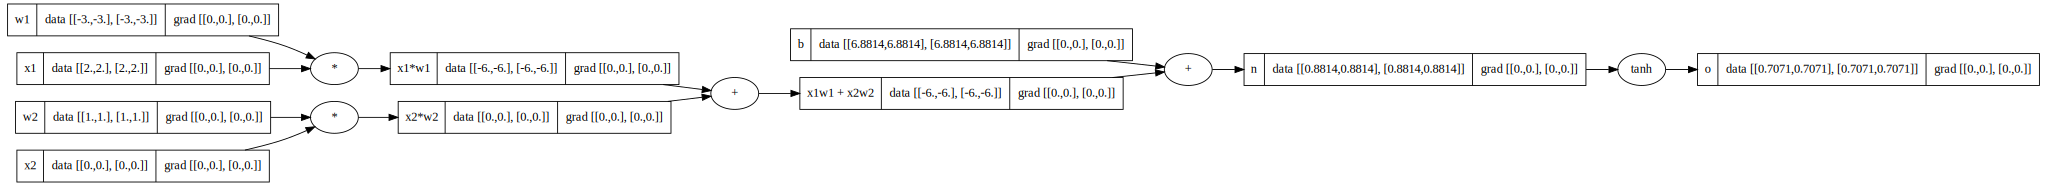

In [3]:
# constructing and visualizing the computation graph for a simple neural network forward pass

# inputs x1, x2
x1 = Value([[2.0, 2.0], [2.0, 2.0]], label="x1")
x2 = Value([[0.0, 0.0], [0.0, 0.0]], label="x2")

# weights w1, w2
w1 = Value([[-3.0, -3.0], [-3.0, -3.0]], label="w1")
w2 = Value([[1.0, 1.0], [1.0, 1.0]], label="w2")

# bias of the neurons
b = Value([[6.8813735870195432, 6.8813735870195432], [6.8813735870195432, 6.8813735870195432]], label="b")

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

# apply the hyperbolic tangent function to n
o = n.tanh(); o.label = 'o'

# visualize the computation graph
draw_dot(o)

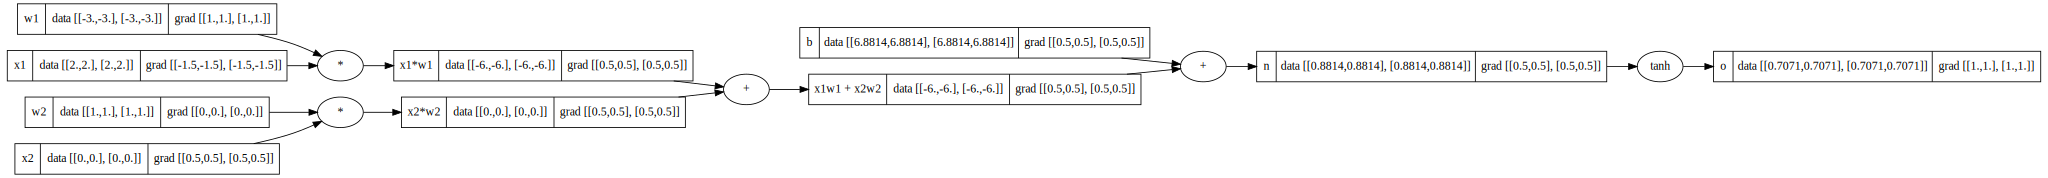

In [4]:
# perform backward propagation to compute gradients
o.backward()

# visualizing the updated computation graph
draw_dot(o)

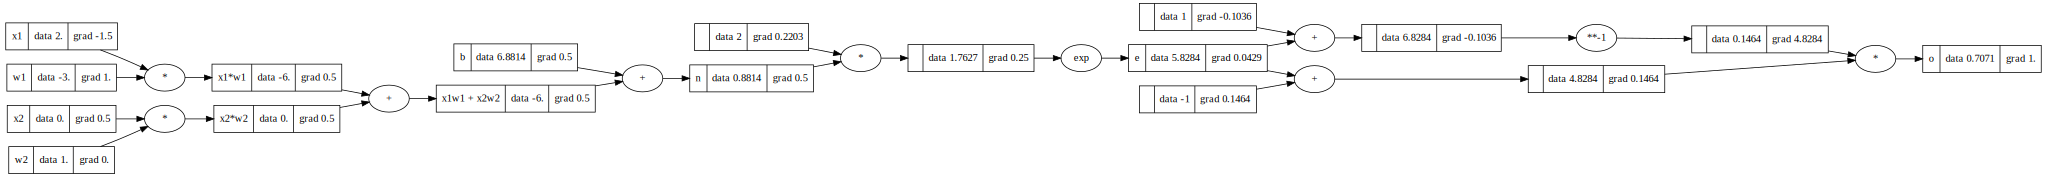

In [5]:
# constructing and visualizing the computation graph for a neural network forward pass and performing backward propagation

# inputs x1,x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights w1, w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# bias of the neurons
b = Value(6.8813735870195432, label="b")

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

# break tanh() into the following expression (hyperbolic tangent)

# computes the value of 'e' by taking the exponential function of the expression '2*n'
e = (2*n).exp(); e.label = 'e'
# computes the value of 'o' using the values of 'e' & subtracts 1 from 'e' and divides it by 'e' plus 1, following a mathematical expression
o = (e - 1) / (e + 1); o.label = 'o'

# perform backward propagation to compute gradients
o.backward()

# visualizing the updated computation graph
draw_dot(o)

In [6]:
import torch

# create tensors and enable gradient tracking

# inputs x1,x2
x1 = torch.Tensor([2.0]); x1.requires_grad = True 
x2 = torch.Tensor([-.0]); x2.requires_grad = True

# weights w1, w2
w1 = torch.Tensor([-3.0]); w1.requires_grad = True  
w2 = torch.Tensor([1.0]); w2.requires_grad = True  

# bias of the neurons
b = torch.Tensor([6.8813735870195432]); b.requires_grad = True

# perform the computation: n = x1*w1 + x2*w2 + b
n = x1*w1 + x2*w2 + b

# apply the hyperbolic tangent function to n
o = torch.tanh(n)

print(o.item())

# perform backward propagation to compute gradients
o.backward()

print("------------")
print("x1", x1.grad.item())
print("w1", w1.grad.item())
print("x2", x2.grad.item())
print("w2", w2.grad.item())

0.7071067094802856
------------
x1 -1.5000003576278687
w1 1.000000238418579
x2 0.5000001192092896
w2 -0.0


In [7]:
import random

class Neuron:

  def __init__(self, nin):
    # Initialize the neuron with random weights and bias between -1 and 1
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # Calculate the weighted sum of inputs multiplied by weights and add the bias
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    # Apply the hyperbolic tangent function to the activation
    out = act.tanh()
    # Return the output of the neuron
    return out
  
  def parameters(self):
    # Return the weights and bias of the neuron as parameters
    return self.w + [self.b]

  
class Layer:

  def __init__(self, nin, nout):
    # Create a layer with a specified number of input and output neurons
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    # Compute the output of each neuron in the layer given an input
    outs = [n(x) for n in self.neurons]
    # If there is only one output neuron, return it directly; otherwise, return a list of outputs
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    # Return the parameters of all neurons in the layer
    return [p for neuron in self.neurons for p in neuron.parameters()]

  
class MLP:

  def __init__(self, nin, nouts):
    # Create a multi-layer perceptron (MLP) with the specified number of input and output neurons for each layer
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    # Forward propagate the input through all layers of the MLP
    for layer in self.layers:
      x = layer(x)
    # Return the final output of the MLP
    return x

  def parameters(self):
    # Return the parameters of all layers in the MLP
    return [p for layer in self.layers for p in layer.parameters()]

In [8]:
# Set the input values
x = [2.0, 3.0, -1.0]

# Create an MLP object with 3 input neurons, 3 hidden layers (each with 4 neurons), and 1 output neuron
n = MLP(3, [4, 4, 1])

# Call the MLP object with the input values
# This triggers the __call__ method of the MLP class
n(x)

Value(data=0.13582530558482833)

In [9]:
# Set the input values for the training examples
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

# Set the desired target values for the training examples
ys = [1.0, -1.0, -1.0, 1.0]

# Training data:
# xs[0] corresponds to ys[0]
# xs[1] corresponds to ys[1]
# xs[2] corresponds to ys[2]
# xs[3] corresponds to ys[3]

In [10]:
for k in range(20):
  
    # Forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))

    # Backward pass
    for p in n.parameters():
        p.grad = 0.0
    
    # Compute gradients using the backward method
    loss.backward()

    # Update weights
    for p in n.parameters():
        p.data += -0.5 * p.grad

    print(k, loss.data)

0 1.7775435867450773
1 0.06611265824278505
2 0.006901234745973038
3 0.005322222223457995
4 0.00435559052011085
5 0.0036985923357483346
6 0.0032213463630148048
7 0.0028582056604797364
8 0.0025722214875243394
9 0.0023409353789170177
10 0.0021498805294869095
11 0.001989303823876685
12 0.0018523837621004615
13 0.0017342022705594778
14 0.0016311220038520088
15 0.0015403936871487
16 0.001459899907529591
17 0.0013879829606015203
18 0.0013233261908806024
19 0.0012648703553402552


In [11]:
# ypred = [n(x) for x in xs]
ypred

[Value(data=0.9954731228138854),
 Value(data=-0.9704885589563487),
 Value(data=-0.9826181423902708),
 Value(data=0.9915546692282492)]